# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import numpy as np

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

2023-06-02 20:41:03.301369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the model class and some custom functions
import sys
sys.path.append('../')
from models import get_vae_model, get_dec_model, compute_p, compute_delta
from clustering_metrics import evaluate_model
from draw_embeddings import draw_embeddings, draw_matched_labels, compare_reconstructed_images_MNIST

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load and prepare the MNIST data set

In [4]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test  = x_test.reshape(-1, 28*28).astype("float")/255

# Construct the VAE based DEC model

## Load the pretrained VAE model

Construct the model and load the pretrained weights from the notebook [vae_on_MNIST.ipynb](./vae_on_MNIST.ipynb)

In [5]:
IMG_DIM    = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)
N_CLUSTERS = 10

model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_vae.load_weights("model_weights/cvae/pretrained/vae")

2023-06-02 20:41:06.995760: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Construc the DEC model

In [6]:
encoder   = models.Model(model_vae.encoder.inputs, model_vae.encoder.outputs[0])
model_dec = get_dec_model(encoder, N_CLUSTERS)

## Show the resulting embeddings

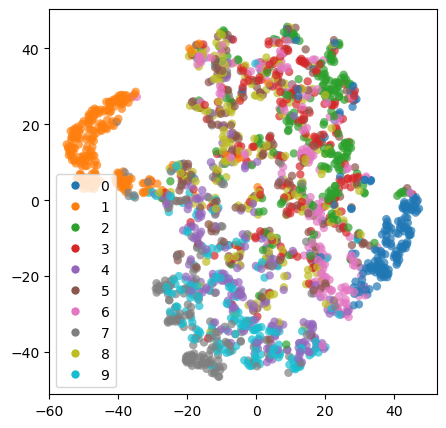

In [7]:
if LATENT_DIM == 2:
    z_test = model_dec.encode(x_test)
    draw_embeddings(z_test, y_test)
else:
    z_test = model_dec.encode(x_test)
    tsne   = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_embeddings(z_tsne, y_test[0:2000])

# Fine-tune the model (K-Means)

## Initialize the parameters

In [8]:
# EPOCHS          = 100 # Recommended number of epochs
EPOCHS          = 5 # Just to test that it works
BATCH_SIZE      = 128
LEARNING_RATE   = 1e-4
# MOMENTUM        = 0.9
SCHEDULE        = 10
DELTA_THRESHOLD = 0.001

Initialize the model parameters from a K-means:

In [9]:
z_train = model_dec.encode(x_train)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_train)

for weight in model_dec.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [10]:
p      = compute_p(to_categorical(kmeans.labels_))
c_last = kmeans.labels_

Evaluate the clustering performance before fine-tunning the model:

{'Acc': 0.4401,
 'ARI': 0.25912495861224355,
 'AMI': 0.4147254912191667,
 'Sil': 0.34863833}

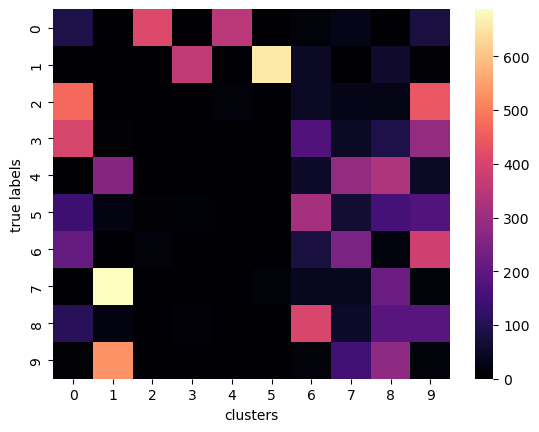

In [11]:
evaluate_model(x_test, y_test, model_dec.classify, model_dec.encode)

## Train the model

Train the model:

In [12]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(x_train)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        print(f"Delta: {delta:.3f}")
        
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

In [13]:
model_dec.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model_dec.fit(x          = x_train,
              y          = p,
              epochs     = EPOCHS,
              batch_size = BATCH_SIZE,
              callbacks  = callback,
              verbose    = 1,
             )

model_dec.save_weights("model_weights/vae_dec/finetuned/dec_kmeans")
# model_dec.load_weights("model_weights/vae_dec/finetuned/dec_kmeans")

Epoch 1/5
469/469 [==============================] - 24s 49ms/step - loss: 9.2136
Epoch 2/5
469/469 [==============================] - 22s 46ms/step - loss: 8.8156
Epoch 3/5
469/469 [==============================] - 21s 46ms/step - loss: 8.3609
Epoch 4/5
469/469 [==============================] - 22s 47ms/step - loss: 7.8798
Epoch 5/5
469/469 [==============================] - 22s 47ms/step - loss: 7.4241


## Show the resulting embeddings

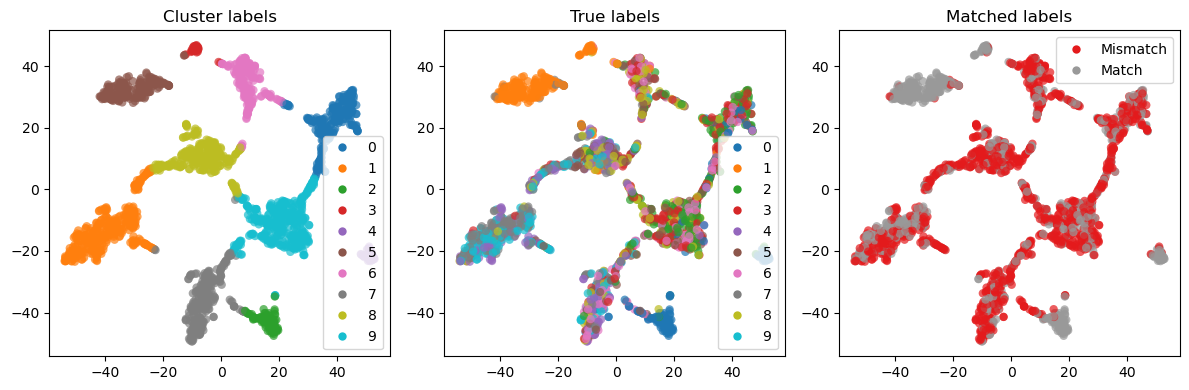

In [14]:
z_test = model_dec.encode(x_test)
c_test = model_dec.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne   = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_matched_labels(z_tsne, y_test[0:2000], c_test[0:2000])

## Evaluate the model

{'Acc': 0.4418,
 'ARI': 0.2638372128613842,
 'AMI': 0.4179605490402955,
 'Sil': 0.7887968}

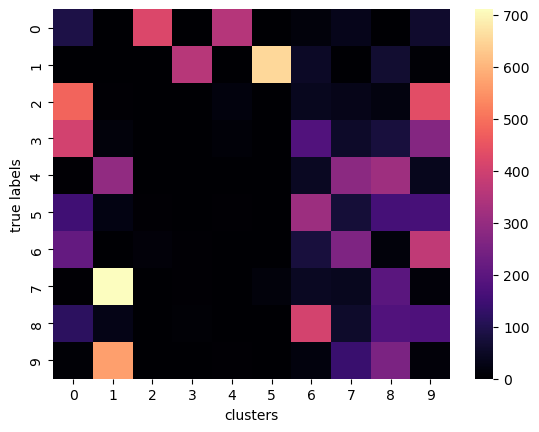

In [15]:
evaluate_model(x_test, y_test, model_dec.classify, model_dec.encode)

# Fine-tune the model (GMM)

## Construct the model and load the pretrained weights

Load the pretrained weights for the encoder and decoder modules:

In [16]:
model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_vae.load_weights("model_weights/cvae/pretrained/vae")
encoder   = models.Model(model_vae.encoder.inputs, model_vae.encoder.outputs[0])
model_dec = get_dec_model(encoder, N_CLUSTERS)

In [17]:
# EPOCHS          = 100 # Recommended number of epochs
EPOCHS          = 5 # Just to test that it works
BATCH_SIZE      = 128
LEARNING_RATE   = 1e-4
# MOMENTUM        = 0.9
SCHEDULE        = 10
DELTA_THRESHOLD = 0.001

## Initialize the parameters

In [18]:
z_train = model_dec.encode(x_train)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=10)
gmm.fit(z_train)

for weight in model_dec.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(gmm.means_))

In [19]:
p      = compute_p(to_categorical(gmm.predict(z_train)))
c_last = gmm.predict(z_train)

Evaluate the clustering performance before fine-tunning the model:

{'Acc': 0.3886,
 'ARI': 0.21064193006275475,
 'AMI': 0.3407746991145659,
 'Sil': 0.20052217}

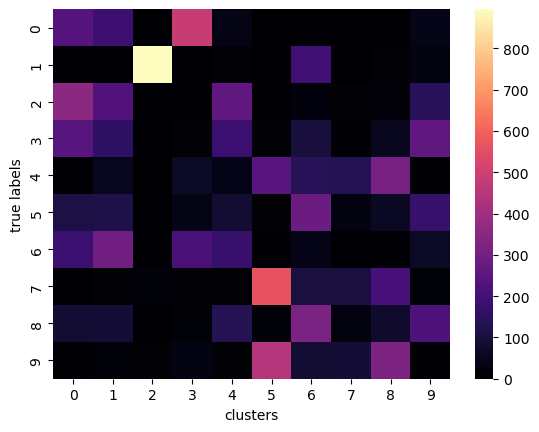

In [20]:
evaluate_model(x_test, y_test, model_dec.classify, model_dec.encode)

## Train the model

In [21]:
model_dec.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model_dec.fit(x          = x_train,
              y          = p,
              epochs     = EPOCHS,
              batch_size = BATCH_SIZE,
              callbacks  = callback,
              verbose    = 1,
             )

model_dec.save_weights("model_weights/vae_dec/finetuned/dec_gmm")
# model_dec.load_weights("model_weights/vae_dec/finetuned/dec_gmm")

Epoch 1/5
469/469 [==============================] - 22s 45ms/step - loss: 10.2160
Epoch 2/5
469/469 [==============================] - 22s 46ms/step - loss: 9.7832
Epoch 3/5
469/469 [==============================] - 21s 45ms/step - loss: 9.3527
Epoch 4/5
469/469 [==============================] - 22s 46ms/step - loss: 8.9173
Epoch 5/5
469/469 [==============================] - 21s 45ms/step - loss: 8.4919


## Show the resulting embeddings

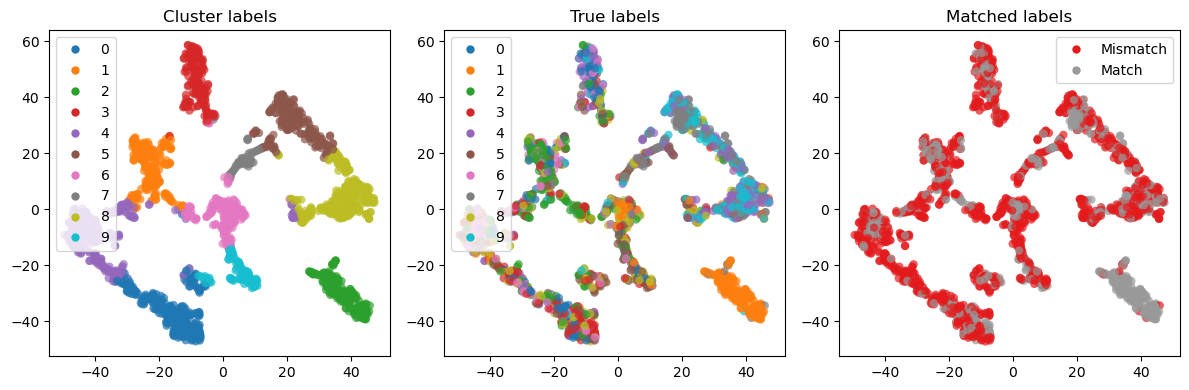

In [22]:
z_test = model_dec.encode(x_test)
c_test = model_dec.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne   = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_matched_labels(z_tsne, y_test[0:2000], c_test[0:2000])

## Evaluate the model

{'Acc': 0.3867,
 'ARI': 0.19472057450523442,
 'AMI': 0.27422230454503527,
 'Sil': 0.6577467}

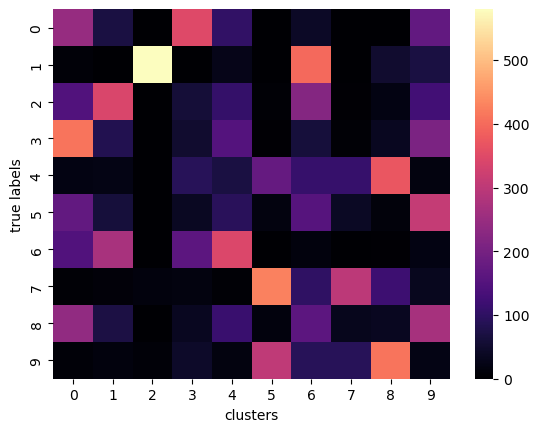

In [23]:
evaluate_model(x_test, y_test, model_dec.classify, model_dec.encode)